# Principais objetivos do trabalho
A partir de um dataset fornecido pelo professor, iremos aplicar um processo conhecido como KDD: Knowledge Discovery in Databases, para treinar um modelo de machine learning que se propõe a, a partir deste Dataset, identificar padrões que o permitam predizer o cargo de uma pessoa baseado em certas informações fornecidas. A preparação do modelo será feita utilizando as técnicas de Floresta Aleatória e Regressão Logística, de modo que os resultados do modelo para cada técnica serão comparados e discutidos ao fim do trabalho.

# Importação do arquivo e das bibliotecas necessárias
Na célula abaixo será feita a importação do arquivo sods.xslx para o código, bem como as importações das diversas bibliotecas que serão utilizadas ao longo de todo o processo. O arquivo xslx contém o dataset, em formato excel, a partir do qual faremos o treinamento do modelo.



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Importando o DataSet
df = pd.read_excel("sods.xlsx")

# Seleção, análise exploratória, pré-processamento e enriquecimento
Nesta etapa, faremos uma análise geral do dataset: suas colunas, seus valores e particularidades. Também explicaremos nossas decisões para o tratamento de dados: a remoção e a não-remoção de certas colunas, bem como o tratamento específico a cada tipo de dado.

# Visão geral do dataset

Na célula abaixo, teremos a primeira visão geral de nosso dataset.

In [2]:
print(df.head())

   idade     genero   etnia  pcd  vive_no_brasil         estado_moradia  \
0   39.0  Masculino   Parda  Não            True  Distrito Federal (DF)   
1   32.0  Masculino   Parda  Não            True              Pará (PA)   
2   53.0  Masculino  Branca  Não            True  Distrito Federal (DF)   
3   27.0  Masculino  Branca  Não            True      Minas Gerais (MG)   
4   46.0   Feminino  Branca  Não            True              Pará (PA)   

            nivel_ensino                                           formacao  \
0          Pós-graduação  Computação / Engenharia de Software / Sistemas...   
1  Graduação/Bacharelado                                 Outras Engenharias   
2          Pós-graduação  Computação / Engenharia de Software / Sistemas...   
3       Doutorado ou Phd  Estatística/ Matemática / Matemática Computaci...   
4          Pós-graduação  Computação / Engenharia de Software / Sistemas...   

                  tempo_experiencia_dados linguagens_preferidas  \
0      

# Observações a respeito da variável alvo
A variável cargo é de suma importância, pois é justamente ela que nosso modelo deve ser capaz de prever. Na célula abaixo, faremos uma investigação a respeito da quantidade de linhas em que a variável cargo é nula. Isto se faz necessário porquê, se existem linhas em que esta variável é nula, logo o seu valor para o nosso modelo também é nulo, pois suas informações não serão significativas para fazer qualquer tipo de predição.

In [3]:
nulos_cargo = df['cargo'].isnull().sum()

print(f"O número de linhas com a variável 'cargo' nula é: {nulos_cargo}")

O número de linhas com a variável 'cargo' nula é: 1290


A investigação acima nos revela que existem 1290 linhas no dataset com a variável cargo nula. Estas linhas precisam ser descartadas para otimização do nosso tratamento de dados. Na célula abaixo, faremos o descarte destas informações.

In [4]:
df_processado = df.dropna(subset=['cargo']).copy()


# Valores nulos em outras colunas
Após descartarmos as linhas em que a coluna "cargo" é nula, precisamos aplicar algum tipo de tratamento para os valores nulos das outras colunas. Primeiro, faremos uma investigação a cerca da quantidade de valores nulos nas outras colunas.

In [5]:
nulos_restantes = df.drop(columns='cargo').isnull().sum()

print("Contagem de valores nulos em todas as colunas, exceto 'cargo':")
print(nulos_restantes)

Contagem de valores nulos em todas as colunas, exceto 'cargo':
idade                        74
genero                        9
etnia                         0
pcd                           0
vive_no_brasil                0
estado_moradia              115
nivel_ensino                  0
formacao                    122
tempo_experiencia_dados     577
linguagens_preferidas      1292
bancos_de_dados            1293
cloud_preferida            1290
dtype: int64


Na análise acima, podemos perceber que algumas colunas não apresentam valores nulos, como: gênero, etnia, pcd, vive_no_brasil e nivel_ensino. Outras, entretanto, possuem grandes quantidades de valores desta natureza. Precisamos aplicar algum tipo de tratamento para estes casos. Iremos começar com as colunas que classificamos como categóricas, isto é, que enquadram uma determinada variável em uma certa categoria. São elas: linguagens_preferidas, bancos_de_dados, cloud_preferida, formacao e estado_moradia.



In [6]:
colunas_categoricas = ['bancos_de_dados', 'linguagens_preferidas', 'cloud_preferida', 'formacao', 'estado_moradia']
for col in colunas_categoricas:
    df_processado[col].fillna("NI", inplace=True)

/tmp/ipython-input-259499132.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processado[col].fillna("NI", inplace=True)


In [7]:
colunas_para_verificar = [
    'bancos_de_dados',
    'linguagens_preferidas',
    'cloud_preferida',
    'formacao',
    'estado_moradia'
]

nulos_apos_tratamento = df_processado[colunas_para_verificar].isnull().sum()

print("Contagem de valores nulos após o tratamento:")
print(nulos_apos_tratamento)

Contagem de valores nulos após o tratamento:
bancos_de_dados          0
linguagens_preferidas    0
cloud_preferida          0
formacao                 0
estado_moradia           0
dtype: int64


# O que foi feito?

Como já explicado anteriormente, valores nulos não possuem valor preditivo para o modelo. Sendo assim, precisamos aplicar algum tipo de tratamento para este tipo de informação. Nas colunas categóricas vistas acima, preenchemos todas as linhas em que os valores eram nulos com a abreviatura "NI", que significa "NÃO INFORMADO". Após executar o código, foi possível verificar na célula acima que os valores nulos para as colunas categóricas agora equivalem a zero.

# Colunas restantes

Nos resta agora as colunas "idade" e "tempo_experiencia_dados". Existe uma diferença fundamental entre elas: a coluna tempo_experiencia_dados é preenchida com um intervalo numérico; a coluna idade, com um número cheio. Precisaremos preencher por completo estas colunas. Para a variável idade, usaremos uma estratégia de imputação pela média. A justificativa para isso é que, no nosso dataset, a distribuição das idades não é muito assimétrica: as idades, em geral, variam entre a casa dos 20 anos de idade e 40, com pouquíssimos outliers. Para uma distribuição como essa, imputar pela média pode ser uma boa estratégia. Abaixo, iremos plotar um gráfico com a distribuição das idades.

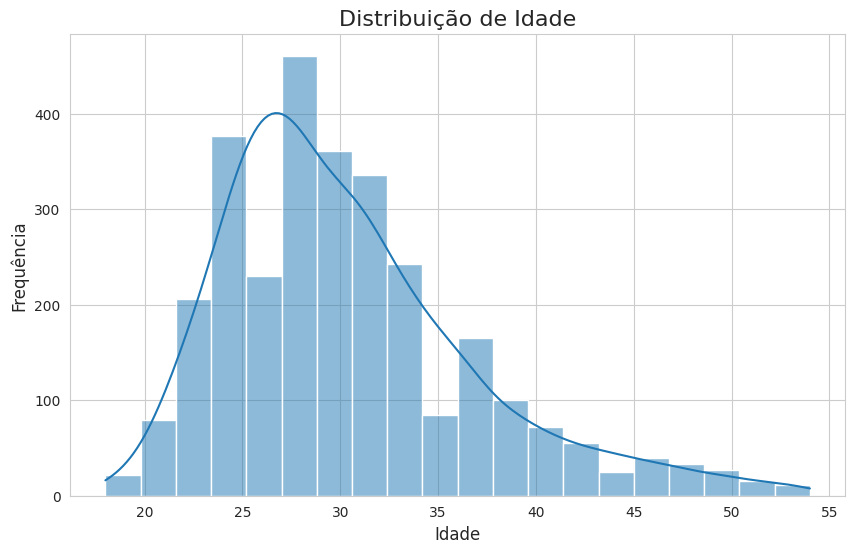

In [8]:
sns.set_style("whitegrid")

# Cria o histograma com KDE (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.histplot(data=df_processado, x='idade', kde=True, bins=20)

# Adiciona título e rótulos
plt.title('Distribuição de Idade', fontsize=16)
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Exibe o gráfico
plt.show()

Como podemos ver na imagem acima, a curva é relativamente normal, em formato de sino, com seus valores diminuindo a medida que o gráfico se afasta do pico.

In [9]:
df_processado['idade'].fillna(df_processado['idade'].mean(), inplace=True)


/tmp/ipython-input-1367013411.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processado['idade'].fillna(df_processado['idade'].mean(), inplace=True)


# E a coluna tempo_experiencia_dados ?

Como mencionado anteriormente, esta coluna é fundamentalmente diferente da coluna idade pois representa um intervalo de tempo, não um valor numérico simples, de modo que é impossível calcular média ou mediana de strings de texto. Poderíamos usar, então, a moda, porém, esta medida seria deveras enganosa; a falta de informação não trás qualquer indício de que o avaliado tenha um tempo de experiência equivalente aos mais frequentes da distribuição. Pelo contrário: a falta de informação, neste caso, pode ser um indicativo da total falta de experiência com dados. Por isso, decidimos preencher os valores nulos desta coluna com "não tenho experiência com dados". Na célula abaixo, aplicamos esta imputação.

In [10]:
df_processado['tempo_experiencia_dados'].fillna('Não tenho experiência na área dados', inplace=True)

/tmp/ipython-input-2876318159.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processado['tempo_experiencia_dados'].fillna('Não tenho experiência na área dados', inplace=True)


In [11]:
colunas_para_verificar = [
    'idade',
    'tempo_experiencia_dados'
]

nulos_apos_tratamento = df_processado[colunas_para_verificar].isnull().sum()

print("Contagem de valores nulos após o tratamento:")
print(nulos_apos_tratamento)

Contagem de valores nulos após o tratamento:
idade                      0
tempo_experiencia_dados    0
dtype: int64


Após o tratamento, ambas as colunas ficaram sem valores nulos, como podemos ver no output da célula acima.

# Dicionários de mapeamento

Ao observar a distribuição de certas categorias de linguagens e bancos de dados, percebemos a presença de valores que consideramos "sinônimos", isto é, valores que, embora não sejam exatamente iguais de um ponto de vista linguístico, representam, na prática, a mesma informação. Por exemplo: valores como "M language" e "M", apesar de textualmente diferentes, referem-se, ambos, à linguagem "M". Outros valores como "Não sei" e "Não utilizo" também podem ser enquadrados como "Nenhum", e assim sucessivamente. Na célula abaixo, verificamos a presença de muitos casos como esse para a distribuição das linguagens preferidas.

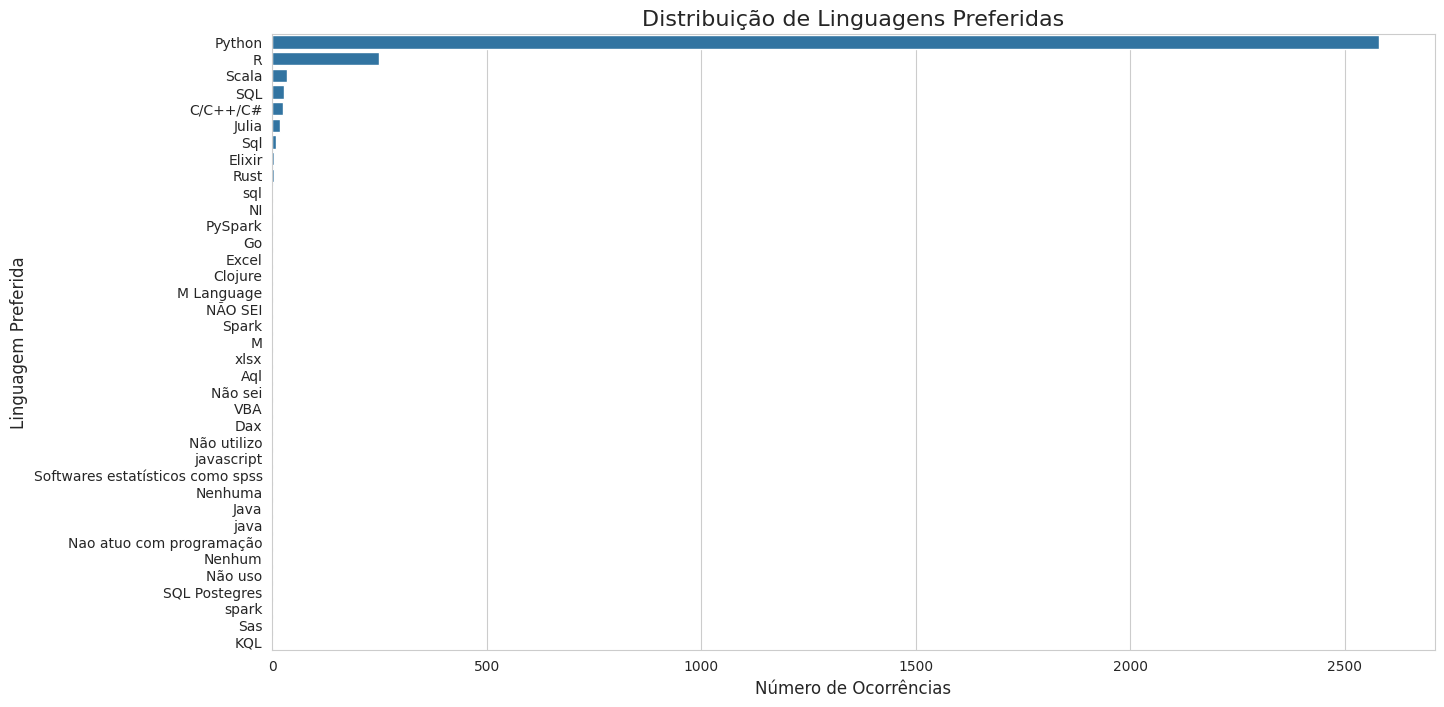

In [12]:
plt.figure(figsize=(15, 8))

sns.countplot(data=df_processado, y='linguagens_preferidas', order=df_processado['linguagens_preferidas'].value_counts().index)

plt.title('Distribuição de Linguagens Preferidas', fontsize=16)
plt.xlabel('Número de Ocorrências', fontsize=12)
plt.ylabel('Linguagem Preferida', fontsize=12)

# Exiba o gráfico
plt.show()

Em virtude disso, decidimos aplicar um dicionário de mapeamento para a coluna linguagem_preferida, visando reduzir o ruído provocado por estas diferenças apenas superficiais.

In [13]:
# --- DICIONÁRIO DE MAPEAMENTO DE LINGUAGENS E BANCOS DE DADOS ---
LINGUAGEM_MAP = {
    'M Language': 'M', 'Não utilizo': 'Nenhuma', 'Nao atuo com pro...': 'Nenhuma',
    'Nenhum': 'Nenhuma', 'Não uso': 'Nenhuma', 'Nenhum desses': 'Nenhuma',
    'Nao utilizo': 'Nenhuma', 'Softwares estatísti...': 'Softwares estatísticos',
    'SQL Postegres': 'SQL', 'java': 'Java','sql':'SQL','Não sei':'Nenhuma'
}

# Bancos de dados
Semelhante prática foi utilizada para otimização da coluna bancos_de_dados. Ao analisar a distribuição desta coluna, verificamos que muitos valores poderiam ser enquadrados em categorias mais abrangentes. Por exemplo: Azure Data Lake e Azure SQL são ambos bancos de dados "Azure", o que justifica enquadrá-los na categoria mais abrangente "Azure". Esta prática de agrupamento foi aplicada para vários casos semelhantes ao longo dos diversos valores da coluna bancos_de_dados do dataset. Este processo, a rigor, não é exatamente o mesmo do que foi feito no caso das linguagens, isto é, o que estamos fazendo aqui não é necessariamente uma anulação de sinônimos(embora haja, também, uma intercessão com esta prática), mas, para além disso, uma incorporação de classes menos abrangentes em classes mais abrangentes, visando diminuir ruídos que possam atrapalhar a capacidade de predição do modelo. Abaixo, uma visão geral da distribuição dos valores mais frequentes desta variável.

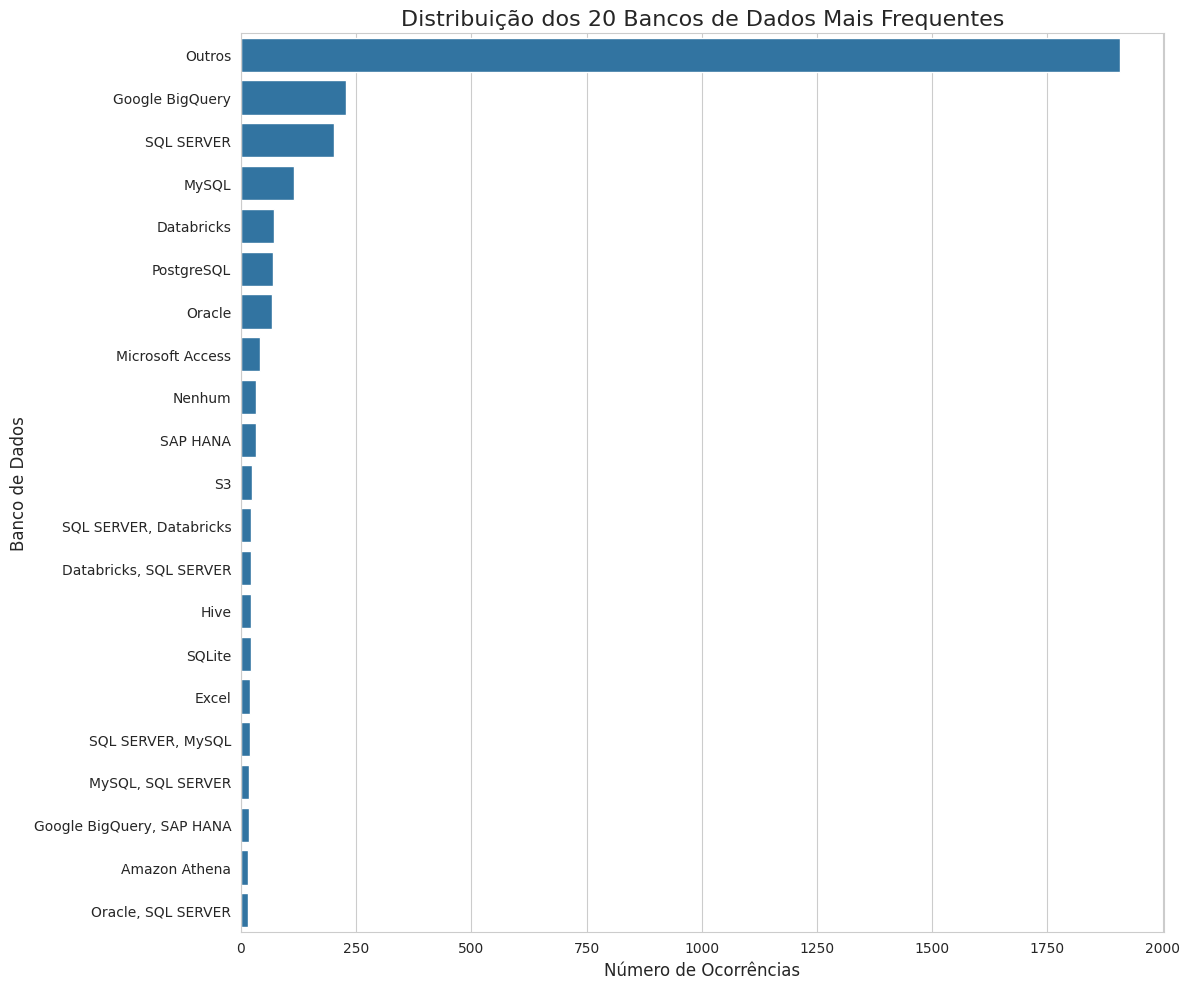

In [15]:
contagem_bancos = df_processado['bancos_de_dados'].value_counts()

top_20_bancos = contagem_bancos.head(20).index

df_top_20 = df_processado.copy()
df_top_20['bancos_de_dados_plot'] = df_top_20['bancos_de_dados'].apply(
    lambda x: x if x in top_20_bancos else 'Outros'
)

plt.figure(figsize=(12, 10))

sns.countplot(
    data=df_top_20,
    y='bancos_de_dados_plot',
    order=df_top_20['bancos_de_dados_plot'].value_counts().index
)

plt.title('Distribuição dos 20 Bancos de Dados Mais Frequentes', fontsize=16)
plt.xlabel('Número de Ocorrências', fontsize=12)
plt.ylabel('Banco de Dados', fontsize=12)

plt.tight_layout()
plt.show()

No gráfico acima, foram plotadas apenas as 20 categorias mais frequentes, em razão da vasta quantidade de valores únicos existentes no dataset para esta coluna. Ainda assim, fica evidente a quantidade de categorias com distinções desnecessárias, que podem ser agrupadas para benefício do modelo de predição. Na célula abaixo, aplicamos nosso dicionário de mapeamento para os bancos de dados.

In [16]:
BANCOS_MAP = {
    'SQL SERVER': 'SQL', 'MSSQL': 'SQL', 'SQL Dbx': 'SQL',
    'Azure Data Lake': 'Microsoft Azure', 'Azure Data lake': 'Microsoft Azure',
    'Azure SQL': 'Microsoft Azure', 'Azure ADLS': 'Microsoft Azure',
    'Azure Synapse': 'Microsoft Azure', 'Azure Storage Account': 'Microsoft Azure',
    'Azure': 'Microsoft Azure', 'MS Azure': 'Microsoft Azure',
    'Google BigQuery': 'Google Cloud', 'Google Big Query': 'Google Cloud',
    'Google Firestore': 'Google Cloud', 'Google Cloud Storage': 'Google Cloud',
    'Bigtable': 'Google Cloud', 'Amazon Aurora ou RDS': 'Amazon',
    'Amazon Athena': 'Amazon', 'Amazon Redshift': 'Amazon', 'S3': 'Amazon',
    'NENHUM': 'Nenhum/Outro', 'interno': 'Nenhum/Outro', 'Não utilizo.': 'Nenhum/Outro',
    'Não atuo ainda nisso': 'Nenhum/Outro', 'Nao utilizo': 'Nenhum/Outro',
    'Nenhuma': 'Nenhum/Outro', 'Não temos BD': 'Nenhum/Outro', 'API': 'Nenhum/Outro',
    'não uso nenhum': 'Nenhum/Outro', 'Não utilizo nenhum': 'Nenhum/Outro',
    'Nenhuma das respostas': 'Nenhum/Outro', 'Nenhum dos listados': 'Nenhum/Outro',
    'Receita': 'Nenhum/Outro', 'NÃO RECONHEÇO NENHUM': 'Nenhum/Outro',
    'Não atuo na área ainda': 'Nenhum/Outro', 'Nao uso': 'Nenhum/Outro',
    'Nenhum desses': 'Nenhum/Outro', 'Não trabalho com banco diretamente': 'Nenhum/Outro',
    'Base interna': 'Nenhum/Outro', 'Dados geoespaciais': 'Nenhum/Outro',
    'Não possuímos um banco de dados.': 'Nenhum/Outro',
    'não utilizamos banco de dados': 'Nenhum/Outro', 'Nenhum acima': 'Nenhum/Outro',
    'Outro': 'Nenhum/Outro', 'OOO': 'Nenhum/Outro',
    'Não trabalho com base de dados.': 'Nenhum/Outro',
    'dados alternativos e dados internos da empresa': 'Nenhum/Outro',
    'Não uso BD no trabalho': 'Nenhum/Outro',
    'Nenhum dos citados acima': 'Nenhum/Outro', 'nosso banco é no excel': 'Nenhum/Outro',
    'Não usamos': 'Nenhum/Outro', 'Dados públicos externos': 'Nenhum/Outro',
    'Não sei': 'Nenhum/Outro', 'Nda': 'Nenhum/Outro',
    'Nao atuo na area de tech na empresa ainda': 'Nenhum/Outro', 'Não se aplica': 'Nenhum/Outro',
    'Nenhum destes': 'Nenhum/Outro', 'Nd': 'Nenhum/Outro',
    'Não utilizo bancos de dados.': 'Nenhum/Outro',
    'Fontes da empresa em html ou csv': 'Fontes não estruturadas',
    'Dados não estruturados': 'Fontes não estruturadas',
    'Dados internos': 'Fontes não estruturadas', 'midias sociais': 'Fontes não estruturadas',
    'Bases Excel e csv extraídas direto no site': 'Excel',
    'B.O SAP': 'SAP', 'SAP Business': 'SAP', 'SAP ECC': 'SAP',
    'SAP HANA': 'SAP', 'HANA': 'SAP'
}

### Aplicando o mapeamento:

In [17]:
def apply_mapping(column, mapping):
    col_str = column.astype(str)
    for original, target in mapping.items():
        col_str = col_str.str.replace(original, target, case=False, regex=False)
    return col_str

df_processado['linguagens_preferidas'] = apply_mapping(df_processado['linguagens_preferidas'], LINGUAGEM_MAP)
df_processado['bancos_de_dados'] = apply_mapping(df_processado['bancos_de_dados'], BANCOS_MAP)

# Tratamento de intervalo numérico

A coluna tempo_experiencia_dados, que foi discutida em seções anteriores, precisa, agora, de novo tratamento. Seus valores correspondem a intervalos numéricos que não podem ser interpretados pelo modelo. Sendo assim, transformaremos estes valores em números propriamente ditos, que poderão ser consumidos com valor interpretativo.



In [18]:
def tratar_intervalo(intervalo):
    if isinstance(intervalo, str):
        if 'Menos de 1 ano' in intervalo: return 0.9
        elif 'Mais de 10 anos' in intervalo: return 10.1
        elif 'Não tenho experiência na área dados' in intervalo: return 0.0
        else:
            try:
                valores = [float(x) for x in intervalo.split(' a ')]
                return sum(valores) / 2
            except ValueError: return 0.0
    return intervalo

df_processado['tempo_experiencia_dados'] = df_processado['tempo_experiencia_dados'].apply(tratar_intervalo)

# Mapeamento e agrupamento de cargos

Em virtude do desbalanceamento do dataset, se torna inerentemente difícil para o modelo obter alta precisão na predição de certos cargos. Muitos cargos minoritários em pouco se diferenciam de categorias mais abrangentes, podendo ser agrupados de modo a aumentar a precisão do nosso modelo. Ao observar a distribuição, notamos a preponderância de três cargos principais: Analista de Dados, Engenheiro/Arquiteto de Dados e Cientista de Dados.

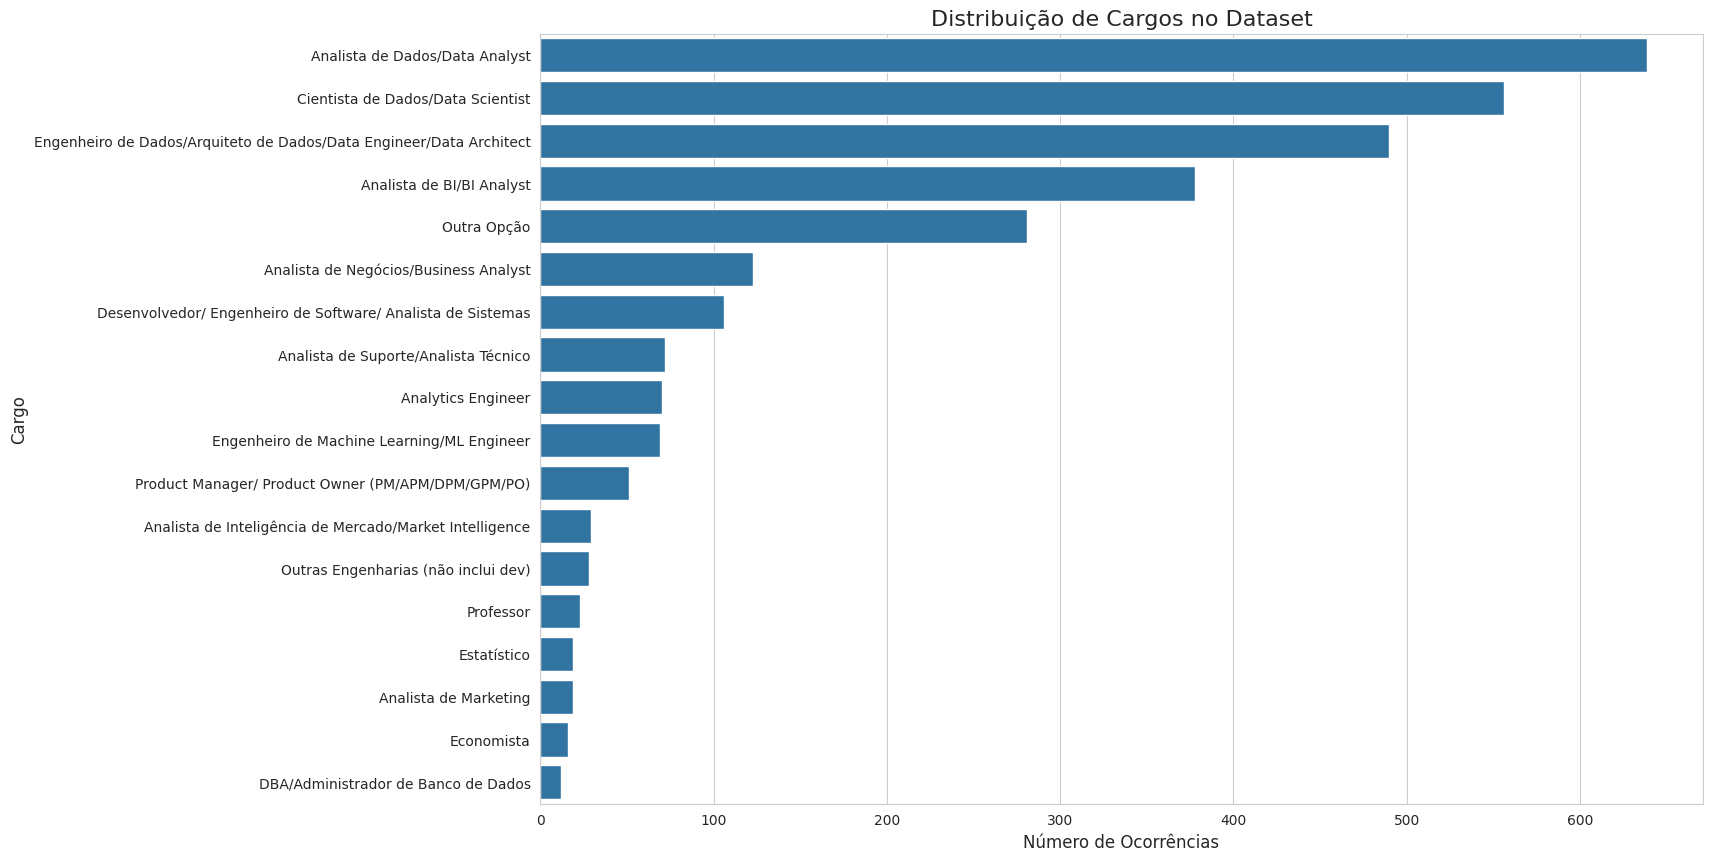

In [19]:
plt.figure(figsize=(15, 10))

sns.countplot(data=df, y='cargo', order=df['cargo'].value_counts().index)

plt.title('Distribuição de Cargos no Dataset', fontsize=16)
plt.xlabel('Número de Ocorrências', fontsize=12)
plt.ylabel('Cargo', fontsize=12)

plt.show()

# Reflexões sobre categorização

No gráfico acima, observamos a dominância de três grandes cargos, seguidos de alguns cargos com boa representatividade(Analista de BI, Analista de Negócios). É possível perceber uma intercessão entre certas categorias. Por exemplo: um Analista de BI ou um Analista de Negócios, são, na prática, Analistas de Dados, mas ocupam estas sub-categorias em virtude da especialização em que aplicam os seus conhecimentos(negócios, business inteligence). Um estatístico é um Cientista de Dados; sua formação o capacita para ser um estudioso dos dados, em suma, um cientista. Um DBA/Administrador de Banco de Dados é, também, um Engenheiro/Arquiteto de Dados, pois sua função envolve organizar dados em modelos relacionais e não-relacionais, utilizando práticas de arquitetura e abstração típicas de qualquer Arquiteto de Dados. Outras categorias, no entanto, são mais problemáticas: um Analista de Sistemas não necessariamente pertence a nenhum dos três grandes grupos; o mesmo se aplica ao Analista de Suporte, Product Manager ou mesmo aqueles que sequer estão enquadrados em um cargo específico, como é o caso daqueles que estão registrados na categoria "Outra Opção". Desta forma, fica aparente a categorização em três principais grupos, os já citados anteriormente - Analista de Dados, Cientistas de Dados e Arquiteto de Dados - e também um outro grupo significativo, isto é, o grupo daqueles cujas profissões não necessariamente envolvem manipulação, estudo ou análise de dados. A esta categoria, chamaremos simplesmente de "Outros". Chegamos, então, a uma categorização em quatro grupos: Analistas de Dados, Cientistas de Dados, Arquitetos de Dados e Outros.

In [20]:
valores_a_substituir = {
    "Analista de Marketing": "Analista de Dados/Data Analyst", "Analytics Engineer": "Analista de Dados/Data Analyst",
    "Analista de Inteligência de Mercado/Market Intelligence": "Analista de Dados/Data Analyst",
    "Analista de BI/BI Analyst": "Analista de Dados/Data Analyst",
    "Analista de Negócios/Business Analyst": "Analista de Dados/Data Analyst",
    "DBA/Administrador de Banco de Dados": "Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect",
    "Engenheiro de Banco de Dados": "Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect",
    "Engenheiro de Machine Learning/ML Engineer": "Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect",
    "Estatístico": "Cientista de Dados/Data Scientist",
    "Desenvolvedor/ Engenheiro de Software/ Analista de Sistemas": "Outros",
    "Economista": "Outros", "Professor": "Outros",
    "Product Manager/ Product Owner (PM/APM/DPM/GPM/PO)": "Outros",
    "Analista de Suporte/Analista Técnico": "Outros", "Outra Opção": "Outros",
    "Outras Engenharias (não inclui dev)": "Outros"
}
df_processado['cargo'] = df_processado['cargo'].replace(valores_a_substituir)


# Preparação para o processamento: formatação

Agora, chegamos ao momento de preparar as features para o processamento. Primeiro, usaremos o target encoder para transformar nossa variável alvo(y) em valores numéricos que possam ser utilizados pelo modelo. Por exemplo, Cientista de Dados pode equivaler a 0, Analistas de Dados a 1, e assim sucessivamente. Depois usaremos o ColumnTransformer para aplicar diferentes tratamentos a diferentes tipos de features. As colunas numéricas serão mantidas como estão; as categóricas serão transformadas em colunas binárias com one-hot-encoding. Features que podem ter mais de um valor como resposta(linguagens_preferidas, bancos_de_dados) passarão por um processo de criação de "dummies", ou seja, colunas com valores numéricos representado os diversos tipos de valores que estas podem assumir. Além disso, outras colunas como gênero, etnia e pcd foram removidas do treinamento. Tomamos esta descisão para evitar a possibilidade de o modelo assumir qualquer viés inadequado. As matrizes geradas pelo ColumnTransformer são empilhadas pelo hstack e um modelo de Floresta Aleatória é treinado temporariamente para observar a importância de cada feature, visando gerar uma nova matriz que tenha apenas as features verdadeiramente relevantes.


In [27]:

# 1. Divisão dos dados em variáveis preditoras (X) e variável alvo (y)
X_df = df_processado.drop(columns=['cargo'])
y = df_processado['cargo']

# 2. Codificação da variável alvo
# Converte os rótulos de texto (nomes dos cargos) em números inteiros,
# que é o formato exigido pelos modelos de machine learning.
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# 3. Definição das colunas para pré-processamento
numerical_features = ['idade', 'tempo_experiencia_dados']
# As colunas 'genero', 'etnia' e 'pcd' foram removidas para evitar vieses.
categorical_features = ['vive_no_brasil', 'estado_moradia', 'cloud_preferida', 'formacao', 'nivel_ensino']

# 4. Criação do pré-processador usando ColumnTransformer
# O ColumnTransformer aplica transformações diferentes em colunas específicas.
preprocessor = ColumnTransformer(
    transformers=[
        # Para colunas numéricas, a transformação é 'passthrough',
        # ou seja, elas não são alteradas.
        ('num', 'passthrough', numerical_features),
        # Para colunas categóricas, o OneHotEncoder é usado para
        # converter cada categoria em uma nova coluna binária (0 ou 1).
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    # As colunas que não foram especificadas nas listas acima são descartadas.
    remainder='drop'
)

# 5. Engenharia de Features para colunas com múltiplos valores
# O .str.get_dummies() transforma strings com múltiplos valores separados por vírgula
# em colunas binárias, uma para cada valor único.
df_linguagens = X_df['linguagens_preferidas'].str.get_dummies(sep=',')
df_bancos = X_df['bancos_de_dados'].str.get_dummies(sep=',')

# Renomeia as colunas para evitar conflitos e mantê-las organizadas.
df_linguagens.columns = [f"lang_{col.strip()}" for col in df_linguagens.columns]
df_bancos.columns = [f"db_{col.strip()}" for col in df_bancos.columns]

# 6. Pré-processamento e união dos dados
# Aplica o pré-processador a X_df para transformar as colunas numéricas e categóricas.
X_preprocessed = preprocessor.fit_transform(X_df)
# Combina horizontalmente (h-stack) os dados pré-processados e as novas colunas
# de linguagens e bancos de dados em uma única matriz final.
X_final = np.hstack((X_preprocessed.toarray(), df_linguagens, df_bancos))

# 7. Identificação dos nomes das features para análise de importância
# Coleta os nomes das features criadas pelo ColumnTransformer e pela engenharia de features
ct_feature_names = preprocessor.get_feature_names_out()
lang_feature_names = df_linguagens.columns.tolist()
db_feature_names = df_bancos.columns.tolist()
all_feature_names = list(ct_feature_names) + lang_feature_names + db_feature_names

# 8. Treinamento temporário para avaliação de importância das features
# Treina um modelo de Random Forest para obter a importância de cada feature.
clf_rf_temp = RandomForestClassifier(random_state=84)
clf_rf_temp.fit(X_final, y_encoded)
importances = clf_rf_temp.feature_importances_

# 9. Seleção das features mais importantes
# Cria um DataFrame para analisar a importância de cada feature.
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
# Filtra as features com importância maior que 0.
important_features_list = feature_importance_df[feature_importance_df['importance'] > 0]['feature'].tolist()

# 10. Criação da matriz final com as features selecionadas
# Seleciona apenas as colunas mais importantes para o conjunto de dados final de treinamento.
# Isso reduz o ruído e melhora o desempenho do modelo.
X_final_selected = X_final[:, [all_feature_names.index(feat) for feat in important_features_list]]

# Divisão dos dados
Na célula abaixo, aplicaremos a divisão de dados hold-out estratificado(70/30) mantendo a proporção das classes da variável alvo cargo, tal qual solicitado no comando do trabalho.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final_selected, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)


## Técnica de Balanceamento

Para este projeto, utilizaremos o ADASYN como técnica de balanceamento. Em virtude da natureza desbalanceada de nossa base, os exemplos das classes majoritárias em muito superam os das classes minoritárias, de modo que algum balanceamento se faz necessário para melhorar a base de dados. Ao pesquisar sobre as melhores técnicas, decidimos por técnicas de OVERSAMPLING, em virtude de conservarem melhor as informações do que as técnicas de UNDERSAMPLING, que consistem em apagar exemplos das classes majoritárias, dispersando informações potencialmente valiosas. Dentre as técnicas de OVERSAMPLING, ficamos entre o SMOTE e o ADASYN; optamos pelo ADASYN. Faremos um breve resumo das duas técnicas e explicaremos o porquê da nossa decisão:

**SMOTE:** gera dados sintéticos de forma mais "uniforme". Ele escolhe aleatoriamente um exemplo da classe minoritária e, em seguida, seleciona aleatoriamente um de seus vizinhos mais próximos. O novo dado sintético é criado em algum ponto ao longo da linha que conecta esses dois exemplos.

**ADASYN:** O ADASYN cria mais dados sintéticos para os exemplos minoritários que são "desafiadores" ou estão em regiões de sobreposição com a classe majoritária. Ele foca em expandir a área de decisão da classe minoritária nas regiões onde a classificação é mais difícil, o que pode levar a um modelo com uma fronteira de decisão mais precisa.

#### Porquê o ADASYN?

O principal desafio da nossa base de dados é o alto grau de sobreposição entre classes majoritárias e minoritárias. A partir das features fornecidas, pode ser muito difícil separar um Analista de Dados de alguém que se enquadre na classe "Outros", por exemplo, pois as tecnologias utilizadas por um e outro se assemelham bastante. Para este caso, o ADASYN se sai melhor, pois ele endereça justamente as zonas de fronteira de decisão que são mais desafiadoras para o modelo e que se fazem frequentes para o presente Dataset.

In [29]:
sm = ADASYN(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Mineração de Dados

Para a etapa de mineração de dados, escolhemos os modelos de Floresta de Decisão e Regressão Logística. Entendemos que a comparações entre os dois modelos é pertinente, isto porquê representam dois paradigmas de ação distintos. A Floresta de Decisão é um modelo robusto e complexo, indicado para casos onde a complexidade é alta e a relação entre as features é não-linear; A Regressão Logística, por outro lado, apresenta um modelo mais simples, adequado para casos onde a relação entre as features e a variável alvo podem ser explicadas por uma combinação linear simples. A comparação entre os dois modelos, portanto, visa esclarecer se a relação entre as características dos profissionais e seus cargos pode ser explicada por uma relação linear simples ou se é necessária uma avaliação mais minuciosa, com a identificação de padrões mais complexos. A julgar pelo andamento do projeto até aqui, é  natural imaginar que o modelo de Floresta Aleatória obterá melhor desempenho.

### Floresta Aleatória


   MODELO 1: RANDOM FOREST   

Melhores Parâmetros Encontrados: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}

--- Avaliação no Conjunto de TESTE ---
Acurácia do Modelo: 0.4949720670391061
Relatório de Classificação:
                                                                      precision    recall  f1-score   support

                                     Analista de Dados/Data Analyst       0.57      0.51      0.54       378
                                  Cientista de Dados/Data Scientist       0.45      0.44      0.45       173
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect       0.48      0.50      0.49       171
                                                             Outros       0.41      0.50      0.45       173

                                                           accuracy                           0.49       895
                                                          macro avg       0.48      0

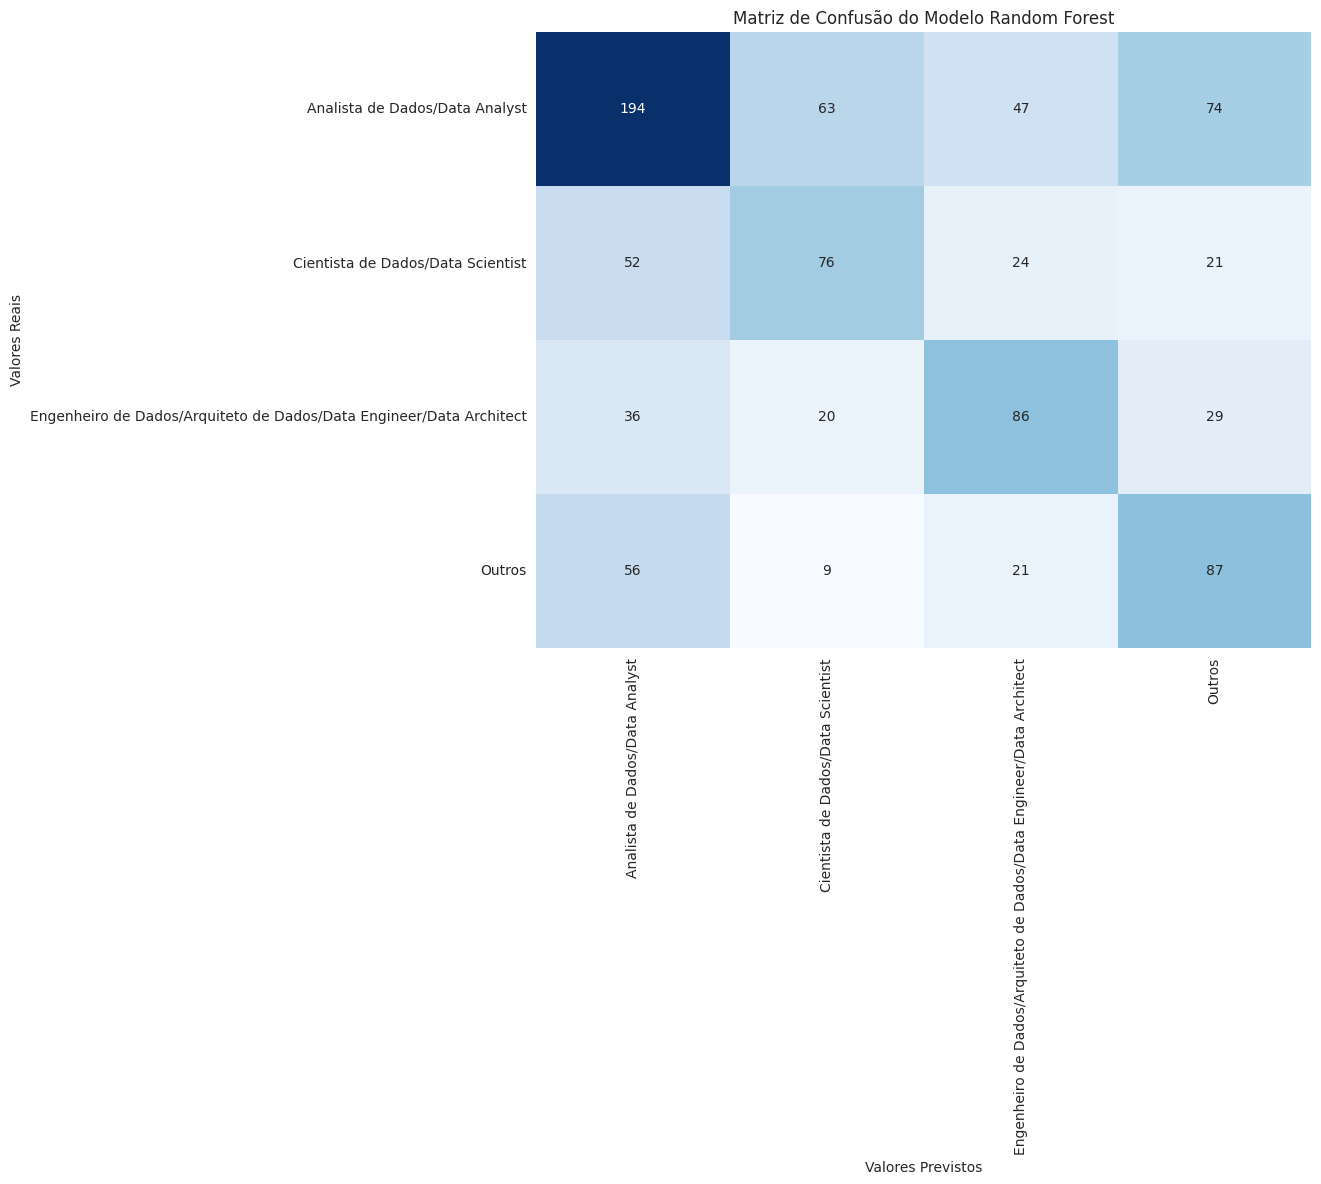

In [33]:
# --- MODELO 1: RANDOM FOREST ---
print("\n" + "="*25)
print("   MODELO 1: RANDOM FOREST   ")
print("="*25 + "\n")

clf_rf = RandomForestClassifier(random_state=84)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

best_clf = grid_search.best_estimator_
y_pred_rf = best_clf.predict(X_test)

print("Melhores Parâmetros Encontrados:", grid_search.best_params_)
print("\n--- Avaliação no Conjunto de TESTE ---")
print("Acurácia do Modelo:", accuracy_score(y_test, y_pred_rf))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_rf, target_names=target_encoder.classes_))

# --- MATRIZ DE CONFUSÃO (NOVO TRECHO) ---
print("\n" + "="*30)
print(" MATRIZ DE CONFUSÃO (RANDOM FOREST) ")
print("="*30 + "\n")

# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred_rf)

# Cria um DataFrame para facilitar a visualização com rótulos
cm_df = pd.DataFrame(cm,
                     index=target_encoder.classes_,
                     columns=target_encoder.classes_)

# Plota a matriz de confusão com seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False) # Remove a barra de cor
plt.title("Matriz de Confusão do Modelo Random Forest")
plt.ylabel("Valores Reais")
plt.xlabel("Valores Previstos")
plt.show()

##

# Análise dos resultados - floresta aleatória
 Para o modelo de Floresta Aleatória, foi encontrada uma precisão de aproximadamente 50%, 49% de recall e 50% de f1 score. Utilizamos o GridSearchCV para encontrar os melhores parâmetros e usamos o f1_macro como medida de decisão para o melhor modelo. Testamos também para a acurácia, mas os numeros foram os mesmos, o que indica que o melhor modelo está obtendo os melhores resultados em todas as principais métricas. Os resultados são razoáveis, mas entendemos que, para a divisão de classes que fizemos, seria difícil obter resultados muito melhores, e mesmo assim, optamos por manter as classes como estão. Isto porquê a divisão das categorias se baseia numa lógica mais guiada pelo bom senso, que separa os profissionais pela natureza de suas ocupações. Poderíamos reduzir o número de classes a três, como fizemos no início do projeto, obtendo uma acurácia superior a 60%; mas isto incorreria em falácias lógicas, como enquadrar um Analista de Sistemas ou de Suporte em alguma categoria de dados, de modo a inflar artificialmente a precisão do modelo.

### Regressão Logística


 MODELO 2: REGRESSÃO LOGÍSTICA 

--- Avaliação no Conjunto de TESTE ---
Acurácia do Modelo: 0.43687150837988825
Relatório de Classificação:
                                                                      precision    recall  f1-score   support

                                     Analista de Dados/Data Analyst       0.57      0.33      0.42       378
                                  Cientista de Dados/Data Scientist       0.39      0.50      0.44       173
Engenheiro de Dados/Arquiteto de Dados/Data Engineer/Data Architect       0.41      0.52      0.46       171
                                                             Outros       0.38      0.53      0.45       173

                                                           accuracy                           0.44       895
                                                          macro avg       0.44      0.47      0.44       895
                                                       weighted avg       0.47      0.44     

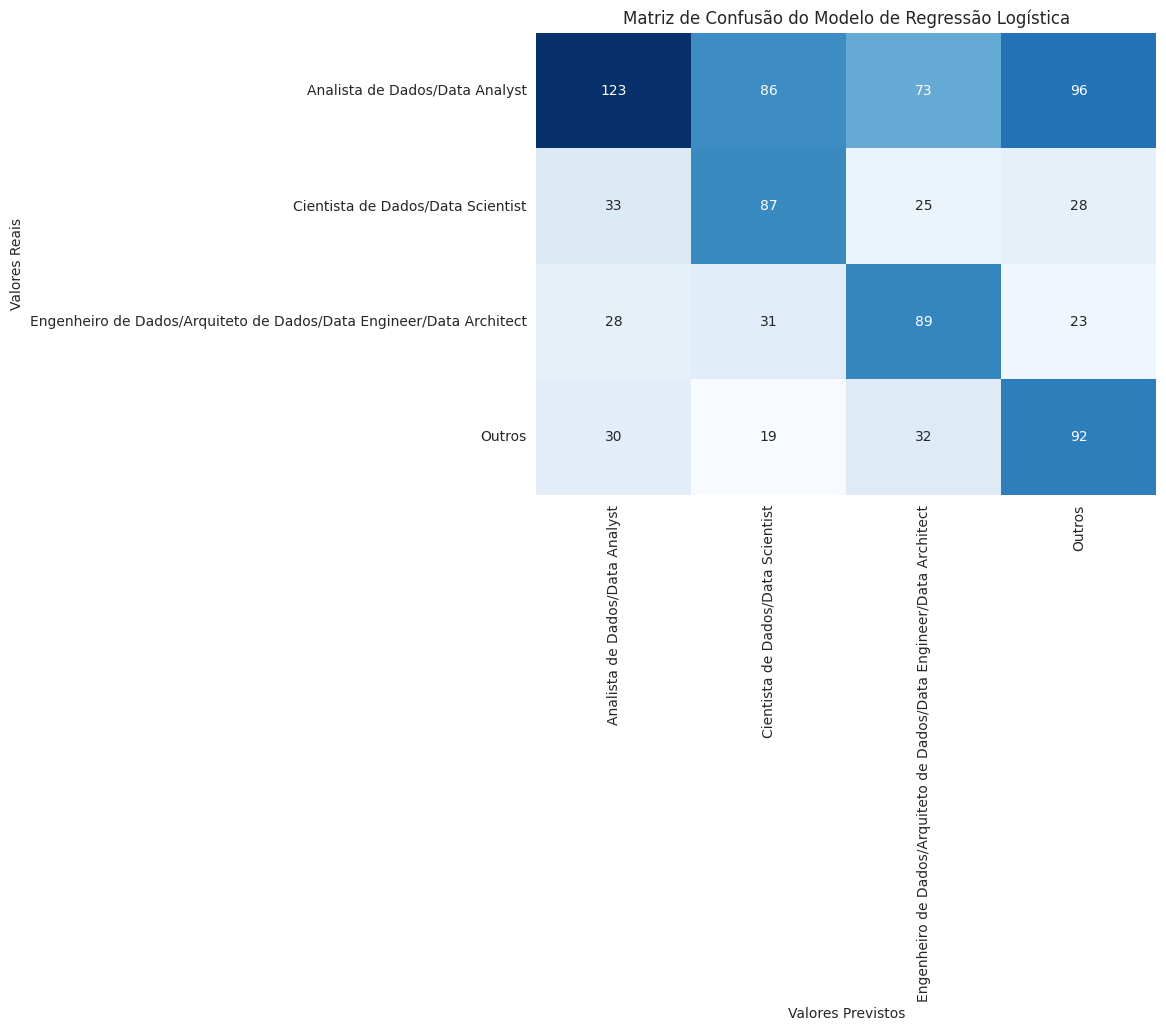

In [36]:

# --- MODELO 2: REGRESSÃO LOGÍSTICA ---
print("\n" + "="*25)
print(" MODELO 2: REGRESSÃO LOGÍSTICA ")
print("="*25 + "\n")

# Instanciando o modelo de Regressão Logística
clf_lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)

# Treinando o modelo no conjunto de treino balanceado
clf_lr.fit(X_train_res, y_train_res)

# Fazendo previsões no conjunto de teste
y_pred_lr = clf_lr.predict(X_test)

# Avaliando o modelo de Regressão Logística
print("--- Avaliação no Conjunto de TESTE ---")
print("Acurácia do Modelo:", accuracy_score(y_test, y_pred_lr))
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_lr, target_names=target_encoder.classes_))

# --- MATRIZ DE CONFUSÃO ---
print("\n" + "="*30)
print(" MATRIZ DE CONFUSÃO (REGRESSÃO LOGÍSTICA) ")
print("="*30 + "\n")

# Gera a matriz de confusão
cm = confusion_matrix(y_test, y_pred_lr)

# Cria um DataFrame para facilitar a visualização com rótulos
cm_df = pd.DataFrame(cm,
                     index=target_encoder.classes_,
                     columns=target_encoder.classes_)

# Plota a matriz de confusão com seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False) # Remove a barra de cor
plt.title("Matriz de Confusão do Modelo de Regressão Logística")
plt.ylabel("Valores Reais")
plt.xlabel("Valores Previstos")
plt.show()


# Análise dos resultados - regressão logística

Em relação ao modelo de Floresta Aleatória, a acurácia do modelo de regressão logística caiu para 44%, o f1 score para 44% e o recall para 47%. Isto demonstra uma clara superioridade do primeiro modelo, o que indica que, de fato, um modelo mais simples é incapaz de captar a não-linearidade característica do nosso problema. Estamos diante de uma base de dados marcada por desbalanceamento e alto grau de sobreposição das features, de modo que o melhor modelo precisa levar em conta estas particularidades.

# Conclusões finais

Após o desenvolvimento e avalição de múltiplos modelos, nossas conclusões demonstram que a complexidade do problema exige um processo de modelagem robust. A Floresta Aleatória superou a Regressão Logística significativamente, indicando que as relações entre características dos profissionais e seus respectivos cargos não são lineares. Apesar dos desafios naturais de um Dataset desbalanceado e com alto grau de sobreposição, o modelo de Floresta Aleatória, otimizado com f1_macro e treinado com balanceamento de dados alcançou uma acurácia e F1 score significativamente mais altos do que um palpite aleatório. Sendo assim, o andamento do projeto ressalta a importância de um pré-processamento minucioso, incluindo engenharia de features e balanceamento das classes como etapas fundamentais para aumentar o desempenho do modelo e obter resultados relevantes.